In [1]:
import sqlite3
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint


from sklearn.tree import export_graphviz
from IPython.display import Image

In [2]:
con = sqlite3.connect("../unified_CD2.db")
cur = con.cursor()
#cur.execute("PRAGMA database_list;")
#cur.fetchall()

In [3]:
df = pd.read_sql_query("SELECT * FROM prod_desc", con)
df.head(3)


,index,id,name,AB,description,OX,source,seq,valid,MaxAbsEStateIndex,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0.0,ADAM_2177,InverPep_ADAM_2177,b'\x01\x00\x00\x00\x00\x00\x00\x00',None,alien,InverPep.fasta,GLFNVFKGLKTAGKHVAGSLLNQLKCKVSGGC,yes,14.846797,...,0,0,0,0,0,0,0,0,5,0
1,NaN,P85444,PPIA_PENGL,b'\x00\x00\x00\x00\x00\x00\x00\x00',Peptidyl-prolyl cis-trans isomerase (Fragment),Penicillium glabrum OX=69773,uniprot_swissprot.fasta,KFADENFQLKH,yes,14.574620,...,0,0,0,0,0,0,0,0,2,0
2,NaN,P85445,ATPD_PENGL,b'\x00\x00\x00\x00\x00\x00\x00\x00',"ATP synthase subunit delta, mitochondrial (Fra...",Penicillium glabrum OX=69773 GN=atp16,uniprot_swissprot.fasta,KIANGSGSEQDIAEAKI,yes,14.109537,...,0,0,0,0,0,0,0,0,2,0


In [4]:
df['fr_term_acetylene'].unique()

array([0])

In [5]:
#reformatting AB to int
df['AB'] = df['AB'].apply(lambda x: int.from_bytes(x, 'little'))

In [6]:
# dropping unique descriptors
descriptors = df.columns[9:]
unidescriptors = [d for d in descriptors if len(df[d].unique()) < 2]
print('len desc, len unidesc', len(descriptors), len(unidescriptors))
print(df.shape)
df.drop(unidescriptors, axis = 1, inplace = True)
print(df.shape)


len desc, len unidesc 210 69
(12801, 219)
(12801, 150)


In [7]:
X = df.drop(['AB', 'index', 'id', 'name', 'valid', 'source', 'seq', 'description', 'OX'], axis = 1)
y = df['AB']
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)
X = X.clip(lower=-1e38, upper=1e38)
X_float = X.astype(np.float32)

#split into test and train

X_train, X_test, y_train, y_test = train_test_split(X_float, y, test_size = 0.30, random_state = 42)



In [44]:
#param_dist = {'n_estimators': randint(50,500),
#             'max_depth': randint(1,20)}
# output from this is basis for next used parameter distribution 

param_dist = {'n_estimators': randint(400,500),
              'max_depth': randint(16,20)}

rf = RandomForestClassifier(random_state = 1)

rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter = 5,
                                 cv = 5)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=5,
                   param_distributions={'max_depth': [16, 17, 18, 19],
                                        'n_estimators': [400, 401, 402, 403,
                                                         404, 405, 406, 407,
                                                         408, 409, 410, 411,
                                                         412, 413, 414, 415,
                                                         416, 417, 418, 419,
                                                         420, 421, 422, 423,
                                                         424, 425, 426, 427,
                                                         428, 429, ...]})

In [45]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)# from 19, 461: 17, 413, 


Best hyperparameters: {'n_estimators': 411, 'max_depth': 18}


In [8]:
# restarting from same parameters 'n_estimators': 411, 'max_depth': 18
best_rf = RandomForestClassifier(random_state=1, n_estimators=411, max_depth=18)
best_rf = best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)


In [46]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8187971882322312
Precision: 0.8341487279843445
Recall: 0.8268671193016489


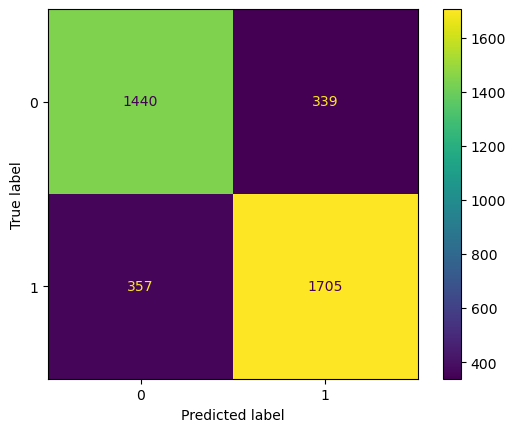

In [47]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

<AxesSubplot:>

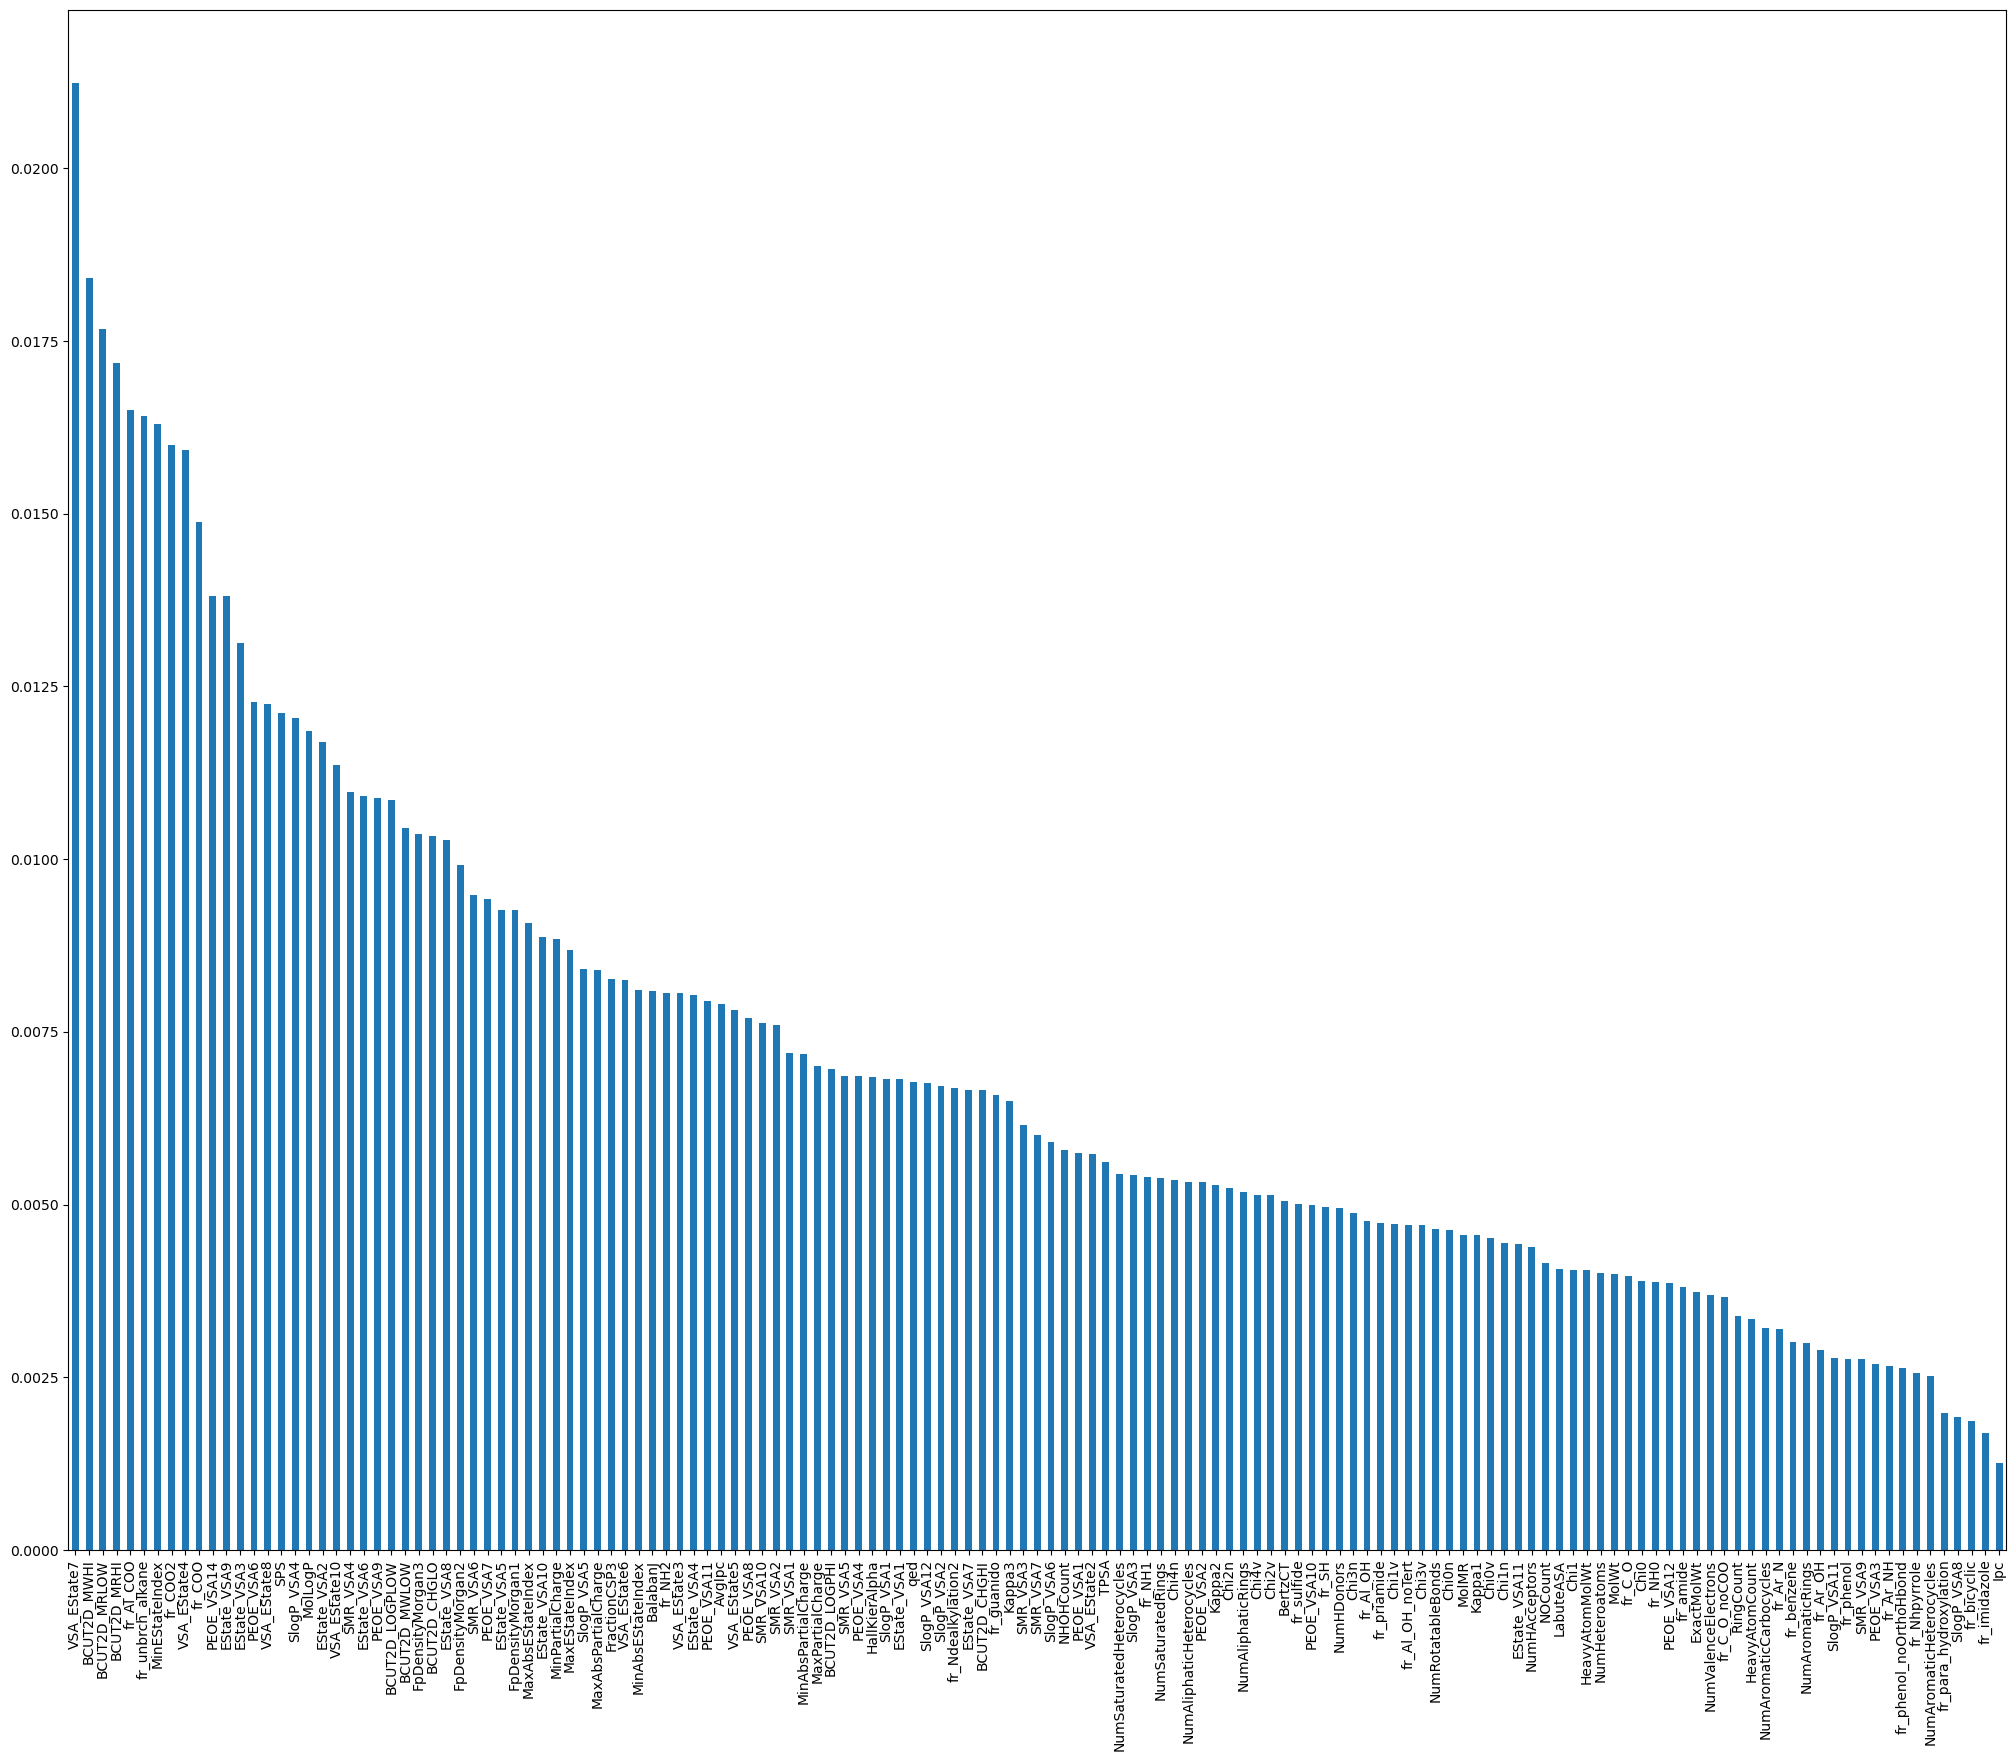

In [48]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar(width = 0.5, figsize =(25, 20))

In [15]:
from sklearn.metrics import roc_curve, roc_auc_score 


y_pred_prob = best_rf.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)

roc_auc = roc_auc_score(y_test, y_pred_prob) 
print('roc_auc: ', roc_auc)

roc_auc:  0.906047436713157


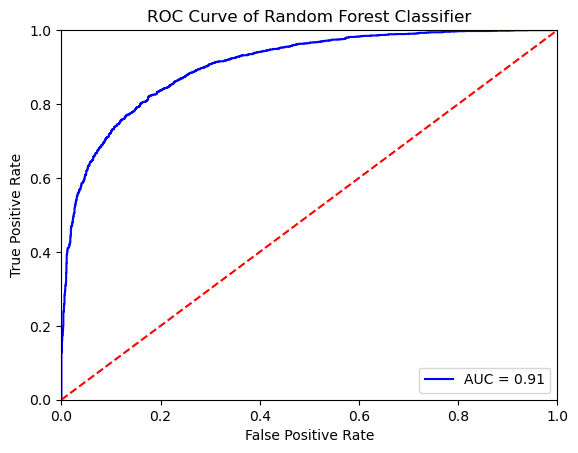

In [50]:

import matplotlib.pyplot as plt

plt.title('Receiver Operating Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of Random Forest Classifier')
plt.show()

In [16]:
X_test.corr()

best_rf.feature_importances_

array([0.00907697, 0.00869131, 0.00810786, 0.01629488, 0.00677132,
       0.01211776, 0.00399123, 0.00405276, 0.0037388 , 0.00368638,
       0.00700436, 0.00884505, 0.00839603, 0.00718144, 0.00925661,
       0.00991347, 0.01036825, 0.01840989, 0.0104439 , 0.00665329,
       0.01032783, 0.0069627 , 0.01085282, 0.01718023, 0.01767614,
       0.00790307, 0.00809387, 0.00505679, 0.00388982, 0.00463174,
       0.00450918, 0.00405811, 0.00444972, 0.00471539, 0.00524067,
       0.00513701, 0.00487751, 0.00469638, 0.00536103, 0.00514379,
       0.00683962, 0.00125506, 0.00455783, 0.00528458, 0.00649947,
       0.00406263, 0.00573917, 0.004992  , 0.00794408, 0.00386352,
       0.01381446, 0.00532084, 0.00269136, 0.0068574 , 0.01228078,
       0.00942472, 0.00769486, 0.01088458, 0.00718665, 0.00762799,
       0.00759541, 0.00615553, 0.01096566, 0.00685957, 0.00948579,
       0.006005  , 0.00276003, 0.00681541, 0.00277579, 0.00676399,
       0.00672125, 0.00543155, 0.01204835, 0.00840863, 0.00590

In [11]:
best_rf.estimators_

[DecisionTreeClassifier(max_depth=18, max_features='sqrt',
                        random_state=1791095845),
 DecisionTreeClassifier(max_depth=18, max_features='sqrt',
                        random_state=2135392491),
 DecisionTreeClassifier(max_depth=18, max_features='sqrt',
                        random_state=946286476),
 DecisionTreeClassifier(max_depth=18, max_features='sqrt',
                        random_state=1857819720),
 DecisionTreeClassifier(max_depth=18, max_features='sqrt', random_state=491263),
 DecisionTreeClassifier(max_depth=18, max_features='sqrt',
                        random_state=550290313),
 DecisionTreeClassifier(max_depth=18, max_features='sqrt',
                        random_state=1298508491),
 DecisionTreeClassifier(max_depth=18, max_features='sqrt',
                        random_state=2143362693),
 DecisionTreeClassifier(max_depth=18, max_features='sqrt',
                        random_state=630311759),
 DecisionTreeClassifier(max_depth=18, max_features